In [1]:
import io
import importlib
import numpy as np
from collections import Counter
from tqdm import tqdm
import precog_utils

importlib.reload(precog_utils)

<module 'precog_utils' from '/Users/ojasvasaxena/Desktop/Research/Precog_Hiring/precog_utils.py'>

### Loading FastText English and Hindi Embeddings
* Downloaded embeddings (text) from [here](https://fasttext.cc/docs/en/crawl-vectors.html).
* Testing the `get_fasttext_embedding` function (returns the embedding of `<UNK>` token if the word is not )

In [2]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())  # header (vocab size, dim)
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        # convert to numpy array
        data[tokens[0]] = np.array(list(map(float , tokens[1:])))
    return data

# load embeddings
fasttext_en = load_vectors("Embeddings/fasttext_en.vec")  # English FastText .vec file
fasttext_hi = load_vectors("Embeddings/fasttext_hi.vec")  # Hindi FastText .vec file

Even though, 'Paper' and 'कागज़' are similar words, they cosine similarity does not catch it yet - as they lie unaligned in the same vector space

In [3]:
w1_en = precog_utils.get_fasttext_embedding("paper" , fasttext_en)
w1_hi = precog_utils.get_fasttext_embedding("कागज़" , fasttext_hi)

print(f"{precog_utils.cosine_similarity(w1_en , w1_hi):.4f}") # similar words, but dissimilar in the vector space

-0.0134


### Bilingual Dictionary
**Reading from our Bilingual Dictionary, created using the help of the oracle of downstream tasks... ChatGPT!**
* I'll be performing Word-Level alignment for this task, as it is simpler and does not require contextual knowledge.
* So, my bilingual dictionary contains `(hindi word , english word)` pairs

In [4]:
import pandas as pd

bilingual_df = pd.read_csv("Corpora/bilingual_dict_chatgpt.csv")
bilingual_df

,token_hi,token_en
0,पूनिया,Poonia
1,यूएचएफ,UHF
2,स्वशिक्षा,self-education
3,ढेले,lumps
4,नियो,Nio
...,...,...
4473,अमूर्त,abstract
4474,भीमबैठका,Bhimbetka
4475,पैरिश,parish
4476,नैटी,Nettie


### Setting up inputs and outputs for Linear Transformatoin and Neural Network to learn the transformation
* Input Matrix: `X` are the Hindi FastText Embeddings from the training set
* Output Matrix (Target): `Y` are the corresponding English FastText Embeddings
* Both are `(num_words)x300` dimensional vectors, which are converted to tensors
* `get_matrix_tensors` will retrun the matrix in list of lists format (X,Y) [for LT] and in tensors format (X_tensor , Y_tensor) [for NN]

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(392)
torch.cuda.manual_seed(392)
torch.cuda.manual_seed_all(392)

def get_matrix_tensors():
    # hindi embedding matrix
    X = []
    for token_hi in bilingual_df['token_hi']:
        X.append(precog_utils.get_fasttext_embedding(token_hi , fasttext_hi))

    # english embedding matrix
    Y = []
    for token_en in bilingual_df['token_en']:
        Y.append(precog_utils.get_fasttext_embedding(token_en , fasttext_en))

    X_tensor = torch.tensor(X)
    Y_tensor = torch.tensor(Y)

    return X , Y , X_tensor , Y_tensor

### Linear Transformation Method : Procrustes Analysis
* Procrustes Analysis involves calculating a Linear Transformation based on the parallel embedding matrices: X and Y
* By solving for the transformation `W`, we can map one set of datapoints `X` to another `Y`. This is exactly what I need, with `X` being a source language (Hindi) and `Y` being a target language (English).
* This is essentially an optimization based on the least sqaures error between the transformed X, and the target Y.
* The operations performed by `W` only involve translations, rotations and scaling.
```math
W = \arg\min_W ||WX - Y||^2
```
```math
W = YX^\top (XX^\top)^{-1}
```

In [6]:
# X,Y matrices will be used for Procrusted Transformation
# X_tensor , Y_tensor will be used later for the Neural Network

X , Y , X_tensor , Y_tensor = get_matrix_tensors()

/var/folders/jl/d933gx354rxgr_msxkqnkc8m0000gp/T/ipykernel_11839/1890879671.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X_tensor = torch.tensor(X)


In [7]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, Y_train, Y_test = train_test_split(X , Y , test_size=test_size, random_state=42)

print(f"Training Set: {len(X_train)}")
print(f"Testing Set: {len(X_test)}")

Training Set: 4030
Testing Set: 448


In [68]:
def procrustes(X , Y):
    # shifts the data so that mean is zero
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)
    
    W = np.linalg.inv(X_centered.T @ X_centered) @ (X_centered.T @ Y_centered)

    return W

In [67]:
W_procrustes = procrustes(X_train , Y_train) # finding the procrustes transformation for the training data

### Visualizing the transformation
* I notice a "squishing" of the hindi embedding space (in 2D) giving us a hint of what the Procrustes transformation might be doing.

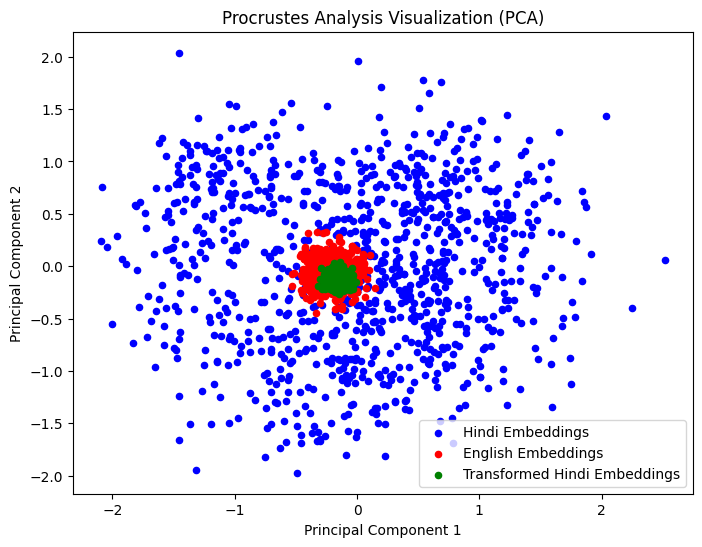

In [74]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

uptil = 1000

X_transformed = X_train[:uptil] @ W_procrustes

# PCA for 2D visualizations
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train[:uptil])
X_transformed_reduced = pca.transform(X_transformed)
Y_reduced = pca.transform(Y)

# plotting the visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:uptil, 0], X_reduced[:uptil, 1], c='blue', marker='o', label='Hindi Embeddings', s=20)
plt.scatter(Y_reduced[:uptil, 0], Y_reduced[:uptil, 1], c='red', marker='o', label='English Embeddings', s=20)
plt.scatter(X_transformed_reduced[:uptil, 0], X_transformed_reduced[:uptil, 1], c='green', marker='o', label='Transformed Hindi Embeddings', s=20)
plt.title('Procrustes Analysis Visualization (PCA)')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Manually assessing the similarity of the alignment
* It's very cool how a simple linear transformation `(O(1)) complexity` is able to get accurate translations post-alignment!
* The outputs are deterministic - literal translation

In [204]:
hindi_token = "दोस्ती"
hindi_token_vec = precog_utils.get_fasttext_embedding(hindi_token , fasttext_hi)

# apply the W transformation after centering
hindi_aligned = (hindi_token_vec - np.mean(hindi_token_vec)) @ W_procrustes

# finding the closest English word
similar_words = precog_utils.similar_embedding_words(fasttext_en, hindi_aligned, topn=10)
print(f"[LINEAR TRANSFORMATION] Aligned to '{hindi_token}' :")
for w in similar_words:
    print(w , end=", ")

[LINEAR TRANSFORMATION] Aligned to 'दोस्ती' :
feelings, friendships, relationship, friendship, life, relationships, affairs, society, finances, ways, 

### Is the opposite true? Does `inv(W)` align English to Hindi??

In [227]:
english_token = "river"
english_token_vec = precog_utils.get_fasttext_embedding(english_token , fasttext_en)

# apply the W transformation after centering
english_aligned = (english_token_vec - np.mean(english_token_vec)) @ np.linalg.inv(W_procrustes)

# finding the closest English word
similar_words_inv = precog_utils.similar_embedding_words(fasttext_hi, english_aligned, topn=50)
print(f"[LINEAR TRANSFORMATION] Inversely Aligned to '{english_token}' :")
for w in similar_words_inv:
    print(w , end=", ")

[LINEAR TRANSFORMATION] Inversely Aligned to 'river' :
करवाकर, फेक, कैनल, दाएँ, ऐटिक, मेटिक, फ़ास्ट, स्वीडिश, मेट्री, बाएँ, कृत्रिम, हंग, अंडर, फ़ॉर, ग्लाइड, रूमेटिक, चुनी, नेत्रिका, तंत्रिका, फ़ासिस्ट, तस्वीर, लिन, नामक, नाइन, बाए, लाइफ़, डेथ, कराई।, जिका, करवायी, जिप्सी, ग्लव्स, बिग, स्किड, फेको, अंगूठाकार, बाइ, अंड, ज़रिए, स्वीट, स्वीडेन, यूरिन, कामयाबी, बैलिस्टिक, रक्ताधान, कैनबिस, चु, करवाई।, फेयर, ताकत, 

In [ ]:
def procrustes(X , Y):
    # shifts the data so that mean is zero
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)
    
    W = np.linalg.inv(X_centered.T @ X_centered) @ (X_centered.T @ Y_centered)

    return W

### Evaluating the results based on Y_test (cosine similarity)
* Final cosine similarity score is the mean across Y_test
* Final Mean Cosine Similarity Score = 0.3962

In [12]:
eval_test_similarities_LT = []

# iterating through test hindi embeddings
for idx,eval_hindi_token_vec in tqdm(enumerate(X_test)):
    truth_target =  Y_test[idx]

    eval_hindi_aligned = (eval_hindi_token_vec - np.mean(eval_hindi_token_vec)) @ W_procrustes
    eval_similar_words = precog_utils.similar_embedding_words(fasttext_en, eval_hindi_aligned, topn=5)

    topn_similarity = []
    for sim_w in eval_similar_words:
        sim_w_embedding = precog_utils.get_fasttext_embedding(sim_w , fasttext_en)
        cur_sim = precog_utils.cosine_similarity(sim_w_embedding , truth_target)
        # print(cur_sim)
        topn_similarity.append(cur_sim)
    eval_test_similarities_LT.append(np.mean(topn_similarity))

print("[LINEAR TRANSFORMATION]")
print(f"Mean Similarity Score (top 5 aligned words) = {np.mean(eval_test_similarities_LT):.4f}")

448it [19:06,  2.56s/it] 

[LINEAR TRANSFORMATION]
Mean Similarity Score (top 5 aligned words) = 0.3962


### Evaluating the results based on Y_test (l2 norm)
* Final col2 norm is the mean across Y_test
* Final Mean L2 Norm ~ 2.3646

In [82]:
eval_test_similarities_LT = []

# iterating through test hindi embeddings
for idx,eval_hindi_token_vec in tqdm(enumerate(X_test)):
    truth_target =  Y_test[idx]

    eval_hindi_aligned = (eval_hindi_token_vec - np.mean(eval_hindi_token_vec)) @ W_procrustes
    eval_similar_words = precog_utils.similar_embedding_words(fasttext_en, eval_hindi_aligned, topn=5)

    topn_similarity = []
    for sim_w in eval_similar_words:
        sim_w_embedding = precog_utils.get_fasttext_embedding(sim_w , fasttext_en)
        cur_sim = np.linalg.norm(sim_w_embedding - truth_target)
        # print(cur_sim)
        topn_similarity.append(cur_sim)
    eval_test_similarities_LT.append(np.mean(topn_similarity))

print("[LINEAR TRANSFORMATION]")
print(f"Mean Similarity Score (top 5 aligned words) = {np.mean(eval_test_similarities_LT):.4f}")

448it [08:52,  1.19s/it]

[LINEAR TRANSFORMATION]
Mean Similarity Score (top 5 aligned words) = 2.3646


### Learning an alignment using a Feed Forward Neural Network
* Although the Procrustes Analysis gives good results, I also attempt to learn potential complex transformations using a Feed Forward Neural Network.
* Might learn non-linear decision boundaries, handling outliers better.
* I can also use regularization techniques, which might make the translations generalize better.

Creating copies of the full embedding tensors (Hindi and English) and getting the training and testing tensors for training/evaluating.

In [16]:
import copy

X_tensor_copy = copy.deepcopy(X_tensor)
Y_tensor_copy = copy.deepcopy(Y_tensor)

In [17]:
X_NN_train, X_NN_test, Y_NN_train, Y_NN_test = train_test_split(X_tensor_copy.clone().detach().type(torch.float32) , Y_tensor_copy.clone().detach().type(torch.float32) , test_size=test_size, random_state=42)

print(f"Training Set: {len(X_NN_train)}")
print(f"Testing Set: {len(X_NN_test)}")

Training Set: 4030
Testing Set: 448


### Building and Training the Neural Network :
**Model Architechture**
>**Input: Hindi Word Embedding (300D)**
↓  
**Linear Layer** (300 → 512)  
↓  
**GELU Activation**  
↓  
**Dropout** (10%)  
↓  
**Linear Layer** (512 → 512)  
↓  
**GELU Activation**  
↓  
**Dropout** (10%)  
↓  
**Linear Layer** (512 → 300)  
↓  
**Output: Predicted Embedding Logits (300D)**
**Loss Function:** Cosine Similarity with true English embedding

* Training data comes from the bilingual dictionary: with Hindi Embeddings as input and their corresponding English Embeddings as target values.
* Loss function returns the `-(Cosine Similarity / L2 Norm + ε)` (OVM INDEX) between predicted logits and the true English embeddings. The -ve is introduced as we need to maximize this value for a good model. In addition to this, I have used the Adam optimizer with a learning rate of 0.003.
* Epochs is set to 1000.

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
torch.manual_seed(392)

# arch for a non-linear alignment
class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim, hidden_dim , output_dim):
        super(EmbeddingMapper, self).__init__()

        # model architechture
        # input -> linear + GELU -> dropout 10% 
        # -> linear + GELU -> dropout 10% -> output logits

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):
        return self.model(x)

# initializing - input/output embedding dims = 300
input_dim = 300
output_dim = 300
hidden_dim = 512
epochs = 1000
learning_rate = 0.003

cross_linguistic_aligner = EmbeddingMapper(input_dim, hidden_dim, output_dim)

# cosine similarity loss function
def loss_fxn(pred, target):
    cosine_sim = precog_utils.batch_cosine_similarity(pred , target).mean()
    l2_norm = torch.norm(pred - target, dim=-1).mean()
    return -(cosine_sim / (l2_norm + 1e-8))  # added epsilon

# adam optimizer
optimizer = optim.Adam(cross_linguistic_aligner.parameters(), lr=learning_rate)

# training loop
for epoch in range(epochs+1):
    hindi_embedding = X_NN_train
    english_embedding = Y_NN_train

    optimizer.zero_grad()
    output = cross_linguistic_aligner(hindi_embedding)
    loss = loss_fxn(output , english_embedding)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5f}")

Epoch 0: Loss = 0.00470
Epoch 50: Loss = -0.35119
Epoch 100: Loss = -0.40266
Epoch 150: Loss = -0.42829
Epoch 200: Loss = -0.45939
Epoch 250: Loss = -0.49474
Epoch 300: Loss = -0.52431
Epoch 350: Loss = -0.56067
Epoch 400: Loss = -0.58957
Epoch 450: Loss = -0.61998
Epoch 500: Loss = -0.64795
Epoch 550: Loss = -0.67206
Epoch 600: Loss = -0.69136
Epoch 650: Loss = -0.70688
Epoch 700: Loss = -0.72245
Epoch 750: Loss = -0.73547
Epoch 800: Loss = -0.75304
Epoch 850: Loss = -0.75953
Epoch 900: Loss = -0.77049
Epoch 950: Loss = -0.77985
Epoch 1000: Loss = -0.79116


### Functions to predict logits for :
* `pred_logits` ouputs predicted English embeddings for a Hindi Word
* `pred_logits_embedding` ouputs predicted English embeddings for a Hindi Embedding

In [175]:
# get output logits (predicted English embedding) through NN input is the hindi word
def pred_logits(hindi_word, fasttext_hi, model):
    hindi_embedding = precog_utils.get_fasttext_embedding(hindi_word , fasttext_hi)
    hindi_embedding = torch.tensor(hindi_embedding , dtype=torch.float32).reshape(1 , -1)
    
    # get o/p logits
    with torch.no_grad():
        pred_logits = model(hindi_embedding)

    return pred_logits.squeeze(0).numpy()


# get output logits (predicted English embedding) through NN input is the hindi embedding
def pred_logits_embedding(hindi_embedding, fasttext_hi, model):
    hindi_embedding = hindi_embedding.clone().detach().type(torch.float32).reshape(1 , -1)
    
    # get o/p logits
    with torch.no_grad():
        pred_logits = model(hindi_embedding)

    return pred_logits.squeeze(0).numpy()

### Manually assessing the similarity of the alignment
* It's also very cool how a neural network is also able learn translations post-alignment!
* The outputs are stochastic - transcreation with some creativity

In [202]:
hindi_word = "दोस्ती"
predicted_embedding = pred_logits(hindi_word , fasttext_hi , cross_linguistic_aligner)

# closest English embedding (cosine similarity)
similar_words = precog_utils.similar_embedding_words(fasttext_en, predicted_embedding, topn=10)
print(f"[NEURAL NETWORK] Aligned to '{hindi_word}' :")
for w in similar_words:
    print(w , end=", ")

[NEURAL NETWORK] Aligned to 'दोस्ती' :
friendship, friends, friendships, relationship, friend, lovers, sisters, relationships, intimacy, house, 

### Evaluating the results based on average Y_test cosine similarity
* Metric: Mean of top 5 most similar (to the predicted logits) English words to the actual translation in the bilingual dictionary
* Final similarity score is the mean across Y_test
* Final Mean Similarity Score (Procrustes Transformation) ~ 0.412
* L2 2.2411

In [180]:
eval_test_similarities_NN = []

# iterating through test hindi embeddings
for idx,eval_hindi_token_vec in tqdm(enumerate(X_NN_test)):
    truth_target =  Y_NN_test[idx]

    eval_predicted_embedding = pred_logits_embedding(eval_hindi_token_vec , fasttext_hi , cross_linguistic_aligner)
    eval_similar_words = precog_utils.similar_embedding_words(fasttext_en, eval_predicted_embedding, topn=5)

    # print(eval_similar_words)

    topn_similarity = []
    for sim_w in eval_similar_words:
        sim_w_embedding = precog_utils.get_fasttext_embedding(sim_w , fasttext_en)
        cur_sim = precog_utils.cosine_similarity(sim_w_embedding , truth_target)
        # print(cur_sim)
        topn_similarity.append(cur_sim)
    eval_test_similarities_NN.append(np.mean(topn_similarity))
    # print()
    # if idx == 10:
    #     break

print("[NEURAL NETWORK]")
print(f"Mean Similarity Score (top 5 aligned words) = {np.mean(eval_test_similarities_NN):.4f}")

448it [08:42,  1.17s/it]

[NEURAL NETWORK]
Mean Similarity Score (top 5 aligned words) = 0.3978


In [181]:
eval_test_similarities_NN = []

# iterating through test hindi embeddings
for idx,eval_hindi_token_vec in tqdm(enumerate(X_NN_test)):
    truth_target =  Y_NN_test[idx]

    eval_predicted_embedding = pred_logits_embedding(eval_hindi_token_vec , fasttext_hi , cross_linguistic_aligner)
    eval_similar_words = precog_utils.similar_embedding_words(fasttext_en, eval_predicted_embedding, topn=5)

    # print(eval_similar_words)

    topn_similarity = []
    for sim_w in eval_similar_words:
        sim_w_embedding = precog_utils.get_fasttext_embedding(sim_w , fasttext_en)
        cur_sim = np.linalg.norm(sim_w_embedding - np.array(truth_target))
        # print(cur_sim)
        topn_similarity.append(cur_sim)
    eval_test_similarities_NN.append(np.mean(topn_similarity))
    # print()
    # if idx == 10:
    #     break

print("[NEURAL NETWORK]")
print(f"Mean Similarity Score (top 5 aligned words) = {np.mean(eval_test_similarities_NN):.4f}")

448it [08:09,  1.09s/it]

[NEURAL NETWORK]
Mean Similarity Score (top 5 aligned words) = 2.2450


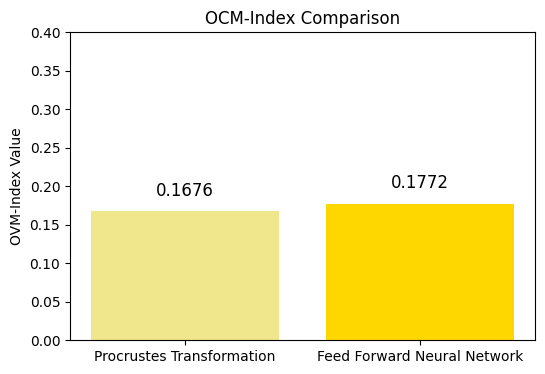

In [205]:
def ovm_index(cs , l2):
    return cs / (l2+1e-8)

ovm_indces = [ ovm_index(0.3962 , 2.3646) , ovm_index(0.3978 , 2.2450) ]
labels = ['Procrustes Transformation', 'Feed Forward Neural Network']

plt.figure(figsize=(6, 4))
plt.bar(labels, ovm_indces, color=['khaki', 'gold'])

plt.ylabel('OVM-Index Value')
plt.title('OCM-Index Comparison')
plt.ylim(0, 0.4)

for i, v in enumerate(ovm_indces):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.show()